
# LoRaSim-AIM: simulate collisions in LoRa using the additive interference model
Extension to the original LoRaSim by Thiemo Voigt <thiemo@sics.se> and Martin Bor <m.bor@lancaster.ac.uk>

This work is licensed under the Creative Commons Attribution 4.0
International License. To view a copy of this license,
visit http://creativecommons.org/licenses/by/4.0/.

In [13]:
# import modules
import simpy
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import os

In [4]:
# This is our custom module
import lorasim_engine as engine

## Hardware Sensitivity

Looking at the changes in receiver sensitivity with changes in bandwidth and spreading factor.

These values are derived from Utz's experiments

In [5]:
## Scaled down configuratons for testing purposes
avgSendTime = 1200000
simtime = 24*3600*1000 # time in ms
packetLength = 20 # in bytes

# log shadow model parameters
Ptx = 30 # in dBm
gamma = 2.2394
# d0 = 40.0 # in m
d0 = 40.0 # from drive tests
var = 0 # variance ignored for now. 
# Lpld0 = 127.41
Lpld0 = 95.0038 # from drive test
GL = 0

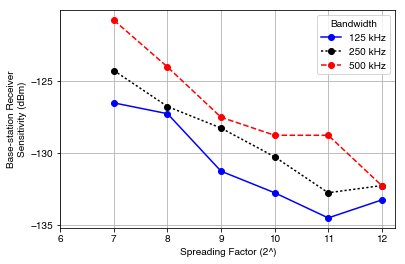

In [6]:
# this is an array with measured values for sensitivity
# see LoRa scaling paper, Table 1

# Note: different receiver hardware will have different values of sensitivity
# However, we assume these values are identical for all our base-stations

sf7 = np.array([7,-126.5,-124.25,-120.75])
sf8 = np.array([8,-127.25,-126.75,-124.0])
sf9 = np.array([9,-131.25,-128.25,-127.5])
sf10 = np.array([10,-132.75,-130.25,-128.75])
sf11 = np.array([11,-134.5,-132.75,-128.75])
sf12 = np.array([12,-133.25,-132.25,-132.25])

# array of sensitivity values
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])

# plotting
def plotSensitivity(sensi):
    sensi_fig = plt.figure()

    s125, = plt.plot(sensi[:,0], sensi[:,1],"bo-", label="125 kHz")
    s250, = plt.plot(sensi[:,0], sensi[:,2],"ko:", label="250 kHz")
    s500, = plt.plot(sensi[:,0], sensi[:,3],"ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Base-station Receiver\nSensitivity (dBm)")
    plt.xticks([6,7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    plt.show()
    
plotSensitivity(sensi)

In [7]:
def airtime(sf,cr,pl,bw):
    H = 0        # implicit header disabled (H=0) or not (H=1)
    DE = 0       # low data rate optimization enabled (=1) or not (=0)
    Npream = 8   # number of preamble symbol (12.25  from Utz paper)

    if bw == 125 and sf in [11, 12]:
        # low data rate optimization mandated for BW125 with SF11 and SF12
        DE = 1
    if sf == 6:
        # can only have implicit header with SF6
        H = 1

    Tsym = (2.0**sf)/bw
    Tpream = (Npream + 4.25)*Tsym
    payloadSymbNB = 8 + max(math.ceil((8.0*pl-4.0*sf+28+16-20*H)/(4.0*(sf-2*DE)))*(cr+4),0)
    Tpayload = payloadSymbNB * Tsym
    return Tpream + Tpayload

def plotAirtime():
    
    cr = 1 # fixed coding rate
    pl = 20 # fixed payload length in bytes
    
    bw_list = [125, 250, 500]
    sf_list = [6, 7, 8, 9, 10, 11, 12]
    
    time_in_air = np.zeros((len(bw_list), len(sf_list)))
    
    for i,bw in enumerate(bw_list):
        for j,sf in enumerate(sf_list):
            time_in_air[i,j] = airtime(sf, cr, pl, bw)
            
    airtime_fig = plt.figure()
    
    at125, = plt.plot(sf_list, time_in_air[0,:], "bo-", label="125 kHz")
    at250, = plt.plot(sf_list, time_in_air[1,:], "ko:", label="250 kHz")
    at500, = plt.plot(sf_list, time_in_air[2,:], "ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [at125, at250, at500])
    plt.grid()
    plt.xlabel("Spreading Factor")
    plt.ylabel("Packet Airtime (ms)")
    plt.xticks([6,7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    
    plt.show()
    
# plotAirtime()

In [8]:
# We need the max transmission distance before we can place nodes

def getUSMaxTransmitDistance(RXSensi, plen, logDistParams):
    """
    Based on the transmit time and bandwidth used, get the parameters which give the best range for allowed power.
    This is dependent on the packet length as the max transmission size is also limited.
    
    TODO: Similar functions should be defined for other regions.
    """
    # Allowed max power for each bandwidth in the US
    
    gamma, Lpld0, d0 = logDistParams
    
    PTx125 = 30 # in dBm
    PTx500 = 26 # in dBm
    
    # The US spec doesn't have a 250 kHz option (and there is no good reason to use it)
    Lpl125 = PTx125 - RXSensi[:,1]
    Lpl500 = PTx500 - RXSensi[:,3]
    
    LplMatrix = np.concatenate((Lpl125.reshape((6,1)), Lpl500.reshape((6,1))), axis=1)
    distMatrix = np.dot(d0, np.exp(np.divide(LplMatrix - Lpld0, 10*gamma)))
    
    packetAirtimeValid = np.zeros((6,2))
    for i in xrange(6):
        packetAirtimeValid[i,0] = (airtime(i+7, 1, plen, 125) <= 400)
        packetAirtimeValid[i,1] = (airtime(i+7, 1, plen, 500) <= 400)
        
    Index = np.argmax(np.multiply(distMatrix, packetAirtimeValid))
    
    sfInd, bwInd = np.unravel_index(Index, (6,2))
    
    if packetAirtimeValid[sfInd, bwInd] == 0:
        raise ValueError("packet length too large")
    
    maxSF = sfInd + 7
    if bwInd == 0:
        maxBW = 125
    else:
        maxBW = 500
    
    return distMatrix[sfInd,bwInd], maxSF, maxBW

===== Location generation =====
Max range = 823.920218138 at SF = 10, BW = 125
generated locations for 1 base-stations
generated locations for 200 nodes


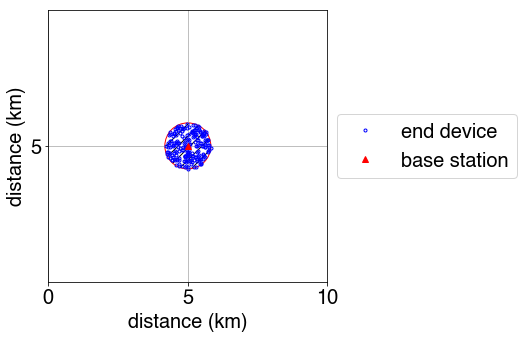

In [9]:
# define the maximum simulation area
maxX = 10000 # in m
maxY = 10000 # in m

# define other the number of nodes in the simulation
maxNrBS = 1
maxNrNodes = 200

BSLoc = np.zeros((maxNrBS, 3))
nodeLoc = np.zeros((maxNrNodes, 3))

bestDist, bestSF, bestBW = getUSMaxTransmitDistance(sensi, packetLength, (gamma, Lpld0, d0))

def placeRandomly(number, locArray, xRange, yRange):
    for n in xrange(number):
        x = random.uniform(xRange[0], xRange[1])
        y = random.uniform(yRange[0], yRange[1])
        locArray[n,:] = [n, x, y]
        
def placeRandomlyInRange(number, locArray, xRange, yRange, refLoc):
    for n in xrange(number):
#         rounds = 0
        while True:
            # This could technically turn into an infinite loop but that shouldn't ever practically happen.
            # add check here later
            x = random.uniform(xRange[0], xRange[1])
            y = random.uniform(yRange[0], yRange[1])
            if np.any(np.sum(np.square(refLoc[:,1:3] - np.array([x,y]).reshape(1,2)), axis=1) <= bestDist**2):
                locArray[n,:] = [n, x, y]
                break
        
print "===== Location generation ====="

# seed the random generator
random.seed(1)

print "Max range = {} at SF = {}, BW = {}".format(bestDist, bestSF, bestBW)

if maxNrBS == 1:
    BSLoc[0] = [0, maxX*0.5, maxY*0.5]
else:
    placeRandomly(maxNrBS, BSLoc, [maxX*0.1, maxX*0.9], [maxY*0.1, maxY*0.9])
print "generated locations for {} base-stations".format(maxNrBS)

placeRandomlyInRange(maxNrNodes, nodeLoc, [0, maxX], [0, maxY], BSLoc)
print "generated locations for {} nodes".format(maxNrNodes)

# np.save("bsList_bs{}_nodes{}.npy".format(maxNrBS, maxNrNodes), BSLoc)
# np.save("nodeList_bs{}_nodes{}.npy".format(maxNrBS, maxNrNodes), nodeLoc)

def plotLocations():
    loc_plot = plt.figure(figsize = (5,5))
    loc_ax = plt.gca()
    
    for b in BSLoc[:,1:3]:
        loc_ax.add_artist(plt.Circle((b[0], b[1]), bestDist, fill=False, hatch='//', color = 'red'))
    
    nodePoints, = plt.plot(nodeLoc[:,1], nodeLoc[:,2], "b.", mfc='none', label="end device")
    bsPoints, = plt.plot(BSLoc[:,1], BSLoc[:,2], "r^", label="base station")
    
    plt.xticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    plt.yticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.axis('equal')
    plt.xlim((0, maxX))
    plt.ylim((0, maxY))
    
    plt.xlabel('distance (km)')
    plt.ylabel('distance (km)')
    
    plt.show()
    
plotLocations()

# Additive interference model

Two major additions from the commonly used Independent Interference model:

1. Interactions consider more than 2 packets at a time
2. We consider interactions between spreading factors for the same frequency (which are otherwise considered to be orthogonal)

All frequencies and references to freqencies in this formulation will be expressed in kHz.

In [1]:
## The Additive Interference Model

# required constants
nSF = 6 # spreading factors used = 6

## This function needs to be redone for the new testing format
def getFreqBucketsFromSet(BSFreqSetList):
    ## This function gives a list of frequencies for various bandwidths used by our base-stations
    ## This is only applicable to the US 902-928 specifications.
    ## Other regions would need their own functions
    
    ## TODO: update this function for white-space frequencies
    
    freqSetList = np.unique(BSFreqSetList)
    freqBuckets = set()
    
    for i in freqSetList:
        freq125.update(np.linspace(902300 + 200*8*i, 903700 + 200*8*i, 8, dtype=int))
        freq500.add(903000 + 1600*i)

    return freq125,freq500

def getAffectedFreqBuckets(fc, bw):
    """This funtion returns a list of affected buckets"""
    
    low = fc - bw/2 # Note: this is approx due to integer division for 125
    high = fc + bw/2 # Note: this is approx due to integer division for 125
    lowBucketStart = low - (low % 200) + 100
    highBucketEnd = high + 200 - (high % 200) - 100
    
    # the +1 ensures that the last value is included in the set
    return xrange(lowBucketStart, highBucketEnd + 1, 200)
    
def getPowerContribution(fc, bw, Ptx, sf):
    """This function should return the power contribution of a packet in various frequency buckets"""
    freqBuckets = getAffectedFreqBuckets(fc, bw)
    nBuckets = len(freqBuckets)
    powermW = 10**(float(Ptx)/10)
    if nBuckets == 1:
        # this is the most common case with 125 kHz BW in the center of the bucket
        signal = np.zeros((nSF,1))
        signal[sf-7] = powermW
        return {freqBuckets[0]:signal}
    elif nBuckets == 4 and fc == freqBuckets[0] + 300:
        # this is the second most common case with 500 kHz BW spread between 4 channels
        signalDict = {}
        for i,freq in enumerate(freqBuckets):
            signal = np.zeros((nSF,1))
            if i == 0 or i == 3:
                signal[sf-7] = 0.1 * powermW
            else:
                signal[sf-7] = 0.4 * powermW
            signalDict[freq] = signal
        return signalDict
    else:
        raise NotImplementedError("non-centered frequencies and 250 kHz not implemented")
        
        ## TODO: implement case when the center frequency is not standard
        ## TODO: implement case for 250 kHz
        
def dBmTomW(PdBm):
    return 10**(PdBm/10.0)

## Spreading Factor Interactions

The interaction matrix between various spreading factors follows the following rules:

1. Same SF must have >6 dBm difference for the stronger packet to get through
2. Different SF's have varying requirements for for Interference + Noise given by (and based on Semtech webinar slides)
    - SF7: -7 dBm
    - SF8: -10 dBm
    - SF9: -12.5 dBm
    - SF10: -15 dBm
    - SF11: -17.5 dBm
    - SF12: -20 dBm
    
We can thus create an interaction matrix given by:

$$
\left(\begin{array}{cc} 
dBmTomW(6) & dBmTomW(-7) & dBmTomW(-7) & dBmTomW(-7) & dBmTomW(-7) & dBmTomW(-7) \\
dBmTomW(-10) & dBmTomW(6) & dBmTomW(-10) & dBmTomW(-10) & dBmTomW(-10) & dBmTomW(-10) \\
dBmTomW(-12.5) & dBmTomW(-12.5) & dBmTomW(6) & dBmTomW(-12.5) & dBmTomW(-12.5) & dBmTomW(-12.5) \\
dBmTomW(-15) & dBmTomW(-15) & dBmTomW(-15) & dBmTomW(6) & dBmTomW(-15) & dBmTomW(-15) \\
dBmTomW(-17.5) & dBmTomW(-17.5) & dBmTomW(-17.5) & dBmTomW(-17.5) & dBmTomW(6) & dBmTomW(-17.5) \\
dBmTomW(-20) & dBmTomW(-20) & dBmTomW(-20) & dBmTomW(-20) & dBmTomW(-20) & dBmTomW(6) \\
\end{array}\right)
=
\left(\begin{array}{cc}
 3.98107171 & 0.19952623 & 0.19952623 & 0.19952623 & 0.19952623 & 0.19952623 \\
 0.1        & 3.98107171 & 0.1        & 0.1        & 0.1        & 0.1        \\
 0.05623413 & 0.05623413 & 3.98107171 & 0.05623413 & 0.05623413 & 0.05623413 \\
 0.03162278 & 0.03162278 & 0.03162278 & 3.98107171 & 0.03162278 & 0.03162278 \\
 0.01778279 & 0.01778279 & 0.01778279 & 0.01778279 & 3.98107171 & 0.01778279 \\
 0.01       & 0.01       & 0.01       & 0.01       & 0.01       & 3.98107171 \\
\end{array}\right)
$$ 

In [16]:
# this is the spreading factor interaction matrix derived from lab tests
interactionMatrix = np.array([
    [dBmTomW(6), dBmTomW(-7), dBmTomW(-7), dBmTomW(-7), dBmTomW(-7), dBmTomW(-7)],
    [dBmTomW(-10), dBmTomW(6), dBmTomW(-10), dBmTomW(-10), dBmTomW(-10), dBmTomW(-10)],
    [dBmTomW(-12.5), dBmTomW(-12.5), dBmTomW(6), dBmTomW(-12.5), dBmTomW(-12.5), dBmTomW(-12.5)],
    [dBmTomW(-15), dBmTomW(-15), dBmTomW(-15), dBmTomW(6), dBmTomW(-15), dBmTomW(-15)],
    [dBmTomW(-17.5), dBmTomW(-17.5), dBmTomW(-17.5), dBmTomW(-17.5), dBmTomW(6), dBmTomW(-17.5)],
    [dBmTomW(-20), dBmTomW(-20), dBmTomW(-20), dBmTomW(-20), dBmTomW(-20), dBmTomW(6)]])

print interactionMatrix

class myBS_AIM():
    def __init__(self, bsid, position, BSFreqSetList, isRogue = False):
        self.bsid = bsid
        self.x, self.y = position
        self.isRogue = isRogue # rogue base-stations do not forward packets even if they recieve it
            
        # RX frequencies are stored as a set for easy searching later
        self.RXFreqBuckets = getFreqBucketsFromSet(BSFreqSetList)
        self.noiseFloor = noiseFloor_AIM(self.RXFreqBuckets)
        self.demodState = set() # stores the current state of the demodulator
        
    def addPacket(self, packet):
        self.noiseFloor.addPacket(packet)
        
    def endPacket(self, packet):
        self.noiseFloor.removePacket(packet)
        
#     def updateRXFreqSet(self, BSFreqSetList):
#         self.RXFreqBuckets = getFreqBucketsFromSet(BSFreqSetList)
        
    
class myNode_AIM():
    def __init__(self, nodeid, position, BSList):
        self.nodeid = nodeid
        self.x, self.y = position
        
        # transmission parameters
        self.PTx = None
        self.fc = None
        self.bw = None
        self.sf = None
        self.cr = None
        self.plen = None
        
        # performance metrics
        self.packetsTransmitted = 0
        self.packetsReceived = 0
        self.BSAffected = [] # List of (base-stations, distance) tuples that are affected by transmissions
            
        for b in BSList:
            dist = np.sqrt((self.x - b.x)**2 + (self.y - b.y)**2)
            if dist <= maxRXDist:
                self.BSinRange.append((b, dist))
            elif dist <= maxIfDist:
                self.BSAffected.append((b, dist))
                
    def updateTxSettings():
        pass
    
class myPacket_AIM():
    def __init__(self, nodeid, bsid, packetno, pTX, distance, fc, bw, sf, cr, plen):
        self.nodeid = nodeid # the source
        self.bsid = bsid # the sink
        self.packetno = packetno
        
        
        self.isCritical = False # This flag is only turned on in the critical section of the preamble
        self.isLost = False # Is the packet lost due to a collision or range problem
        self.signalLevel = {} # stores the signal level in each packet
    
class noiseFloor_AIM():
    def __init__(self, freqBuckets):
        
        noiseBucket = {}
        packetsInBucket = {}
        for freq in freqBuckets:
            noiseBucket[freq] = np.zeros(nSF)
            packetsInBucket[freq] = [] 
    
    def addPacket(self, packet):
        # Add a packet to the noise floor and immediately evaluate it's contribution on the 
        pass
    
    def removePacket(self, packet):
        # Remove a packet from the noise floor
        pass
    
    def evaluate(self, target = None):
        # Evaluate all active packets
        pass
    
## various types of transmit functions define each individual experiment

def transmitPacket(env, node, BSCollection):
    # this assumed the radio assignemnts for a node are static, and do not change later
    # We select a given static assignment in the whole network
    while True:
        # The inter-packet waiting time. Assumed to be exponential here.
        yield env.timeout(random.expovariate(1.0/float(node.period)))
        
        # update settings if any
        node.updateTxSettings()
        
        node.packetno += 1
        # send a virtual packet to each base-station in range and those we may affect
        for bsid, distance in node.BSAffected:
            packet = myPacket_AIM(node.nodeid, bsid, node.packetno, node.PTx, distance, node.fc, node.bw, node.sf, node.cr, node.plen)
            BSCollection[bsid].addPacket(packet)
            
        Npreamb = 8 # assuming 8 preamble symbols
        Tcritical = (2**node.sf/nod.bw)*(Npreamb - 5) # time until the start of the critical section

        
        # wait until critical section starts
        yield env.timeout(Tcritical)
        
        for bsid, distance in node.BSAffected:
            BSCollection[bsid].makeCritical(node.nodeid, node.packetno)
            
        Trest = airtime(node.sf,node.cr,node.plen,node.bw) - Tcritical # time until the rest of the message completes
        
        yield env.timeout(Trest)
        
        successfulRx = False
        for bsid, distance in node.BSAffected:
            if BSCollection[bsid].endPacket(node.nodeid, node.packetno):
                successfulRx = True
                
        node.packetsTransmitted += 1
        if successfulRx:
            node.packetsReceived += 1
                

[[ 3.98107171  0.19952623  0.19952623  0.19952623  0.19952623  0.19952623]
 [ 0.1         3.98107171  0.1         0.1         0.1         0.1       ]
 [ 0.05623413  0.05623413  3.98107171  0.05623413  0.05623413  0.05623413]
 [ 0.03162278  0.03162278  0.03162278  3.98107171  0.03162278  0.03162278]
 [ 0.01778279  0.01778279  0.01778279  0.01778279  3.98107171  0.01778279]
 [ 0.01        0.01        0.01        0.01        0.01        3.98107171]]
